# Interactive Julia for *Radial Subgradient Method* #

### Benjamin Grimmer ###
___

This notebook follows along the ideas presented in [[1]](https://arxiv.org/abs/1703.09280). Its purpose is to give a simple and understandable implementation of the algorithms and concepts therein. Throughout this document, we will provide references to equations, lemmas, and theorems using the numbering given in that paper. 

The general outline of this document is the following:

1. Implementation of Basic Transformation
2. Examples of Applying the Transformation in One and Two Dimensions
3. Implementation of the Radial Subgradient Method
4. Solving Some Simple Problems:
    * Piecewise Linear Minimization
    * Regression with Sparse Regularization
5. Solving an Interesting Problem 
    * Finding the Analytic Center of a Polyhedron
    * Linear Programming

**Disclaimer**: We make no claim that the code below is optimized or the most efficient version possible. Instead our goal is to give the simplest implementation possible. Speedups are certainly possible using optimized linear algebra packages and by taking advantage of sparsity and parallelization schemes.

Any questions or feedback on this document can be sent to Ben Grimmer at *bdg79@cornell.edu*.

[1] "Radial Subgradient Method", https://arxiv.org/abs/1703.09280. Benjamin Grimmer. First posted March 27th, 2017.

# Implementation of Basic Transformation #

Central to this paper is a transformation originally proposed by Renegar [here](https://doi.org/10.1137/15M1027371) in the context of conic programming. This paper however deals with it entirely from the perspectice of minimizing convex functions (which is equivalent). In our context, we consider a convex function

$$ f : \mathbb{R}^n \rightarrow (-\infty, +\infty],$$

where $f(x)=+\infty$ denotes an infeasible solution.

We make one structural assumption on the function $f$: 

$$ \vec 0 \in \mathrm{int\ dom\ } f \text{ and } f(\vec 0)<0.$$

This assumption is easily satisfied if a strictly feasible point is known. Then one only needs to translate the function to place that point at the origin and then add a constant to $f$ to ensure a negative function value there.

Given such a function, the radial reformulation of $f$ of level $z<0$ is the following:

$$ \gamma_z(x) = \inf\{ \gamma>0 \mid f(x/\gamma) \leq z/\gamma\}.$$

### Example 1 - Maximum of Linear Functions ###
Suppose $f$ is defined as the maximum of $m$ linear functions:
$$ f(x) = \max_{i=1\dots m} (a_i^T x +b_i).$$

In this case, we can compute $\gamma_z$ in closed form. The corresponding formula can be dirived directly:
\begin{align}
\gamma_z(x) & = \inf\{\gamma>0 \mid \max_{i=1\dots m} (a_i^T x/\gamma +b_i) \leq z/\gamma\}\\
& = \inf\{\gamma>0 \mid \max_{i=1\dots m} (a_i^T x + b_i\gamma) \leq z\}\\
& = \max_{i=1\dots m}\left\{\frac{z - a_i^Tx}{b_i}\right\}
A\end{align}

This is implemented in the following code:

In [39]:
m,n = 10,1
A = randn(m,n)
b = 5*rand(m) - 6.0*ones(m);

In [2]:
"Piecewise linear convex function defined as maximum of linear functions."
function maxLinear(x)
    return maximum(A*x + b)
end

"Reformulation of above piecewise linear problem, which also happens to be a convex piecewise linear problem"
function gammaZ_maxLinear(x,z)
    return maximum((z*ones(m) - A*x)./b)
end;

### Computing $\gamma_z$ for General Functions###
For general functions $f$, we may not have a closed form for $\gamma_z$. However, it can be computed to high accuracy using a simple one dimensional line search. Further, the convexity of $f$ makes this line search amenable to bijection (so it can be computed to high precision with a fixed number of function evaluations).

The following code implements this:

In [3]:
"Higher-Order function that produces the radial reformulation of f of level z"
function radialReformulation(f, z)
    "Conduct a linesearch to find the value of gamma"
    function gammaZ(x)
        #Easy lower bound on function value
        low = 0.0        
        #Compute an uppebound using an exponential backoff
        high=1.0
        for i in 1:32 #Values bigger than 2^32 will be considered infinity
            if f(x/high) < z/high
                break
            end
            low = high
            high = high*2
        end
        if high >= 2^32 return 0 end
        
        #Do a binary search between high and low
        while high-low > 10.0^-9
            mid = (high+low)/2
            if f(x/mid) < z/mid
                high = mid
            else 
                low = mid
            end
        end
        if low == 0.0 return Inf end #Values less than 10^-6 will be considered zero
        return high
    end
    return gammaZ
end;

# Examples of Applying the Transformation in One and Two Dimensions #

Central to the strength of the results of this paper are the nice structural properties of $\gamma_z$. In particular,
1. $\gamma_z$ is finite everywhere and thus has full domain.
2. $\gamma_z$ is convex and Lipschitz continuous (see our Proposition 2.2).
3. the set of minimizers of $\gamma_z$ is exactly (z/f^*) times the set of minimizers of $f$ (see our Proposition 2.3).

All of these properties can be readily seen by looking at plots of pairs of $f$ and $\gamma_z$. Further this transformation is highly geometric in nature and thus plots help build intuition for the underlying structure. So we will give three examples of this transformation that illistrate different properties of it.

### Reformulating Piecewise Linear Functions ###
We have already seen that piecewise linear convex functions have a closed form for $f$. Using the function definitions from before, we can see how the function changes in this simplest case:

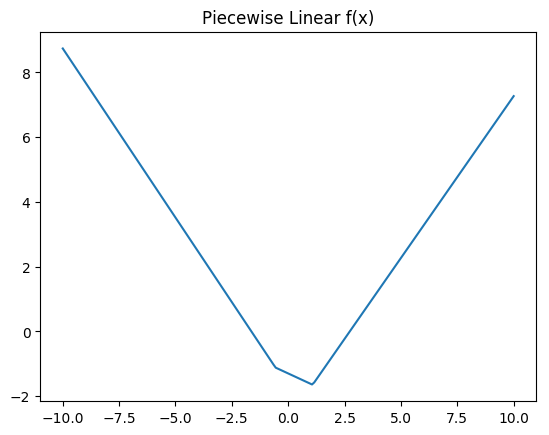

In [40]:
using PyPlot
title("Piecewise Linear f(x)")
plot(linspace(-10, 10, 200), maxLinear.(linspace(-10, 10, 200)));

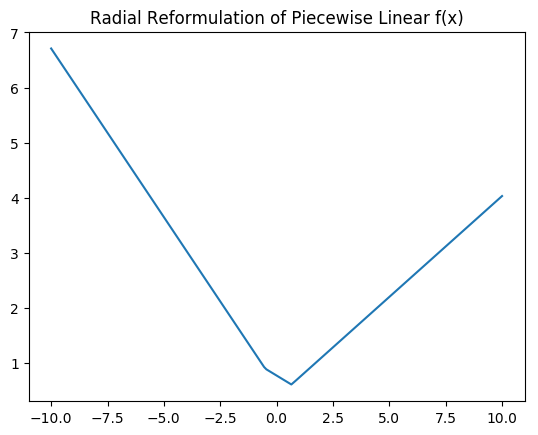

In [41]:
title("Radial Reformulation of Piecewise Linear f(x)")
plot(linspace(-10, 10, 200), gammaZ_maxLinear.(linspace(-10, 10, 200),-1));

### Reformulating Constrained Optimization Problems ###

One of the incredibly useful properties of $\gamma_z$ is that it has full domain. As a result any constrained convex optimzation problem can turned into an unconstrained optimization problem. To illustrate this, we consider the following contrived function defined on $[-1,1)$:

$$ f(x) = \begin{cases} x^2 -log(1-x) -1 & \text{ if } x\in[-1,1)\\ +\infty & \text{ otherwise.}\end{cases}$$

This function and its reformulation are shown below:

In [6]:
"A contrived function that blows up asymptotically towards 1 and suddenly at -1"
function contrived_f(x)
    if abs(x)<1
        x^2 - log(1-x) -1
    else
        Inf
    end
end

gamma_contrived = radialReformulation(contrived_f, -1.0);

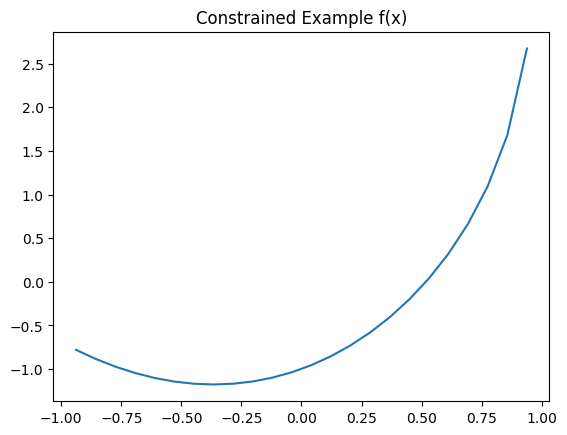

In [7]:
title("Constrained Example f(x)")
plot(linspace(-2, 2, 50), contrived_f.(linspace(-2, 2, 50)));

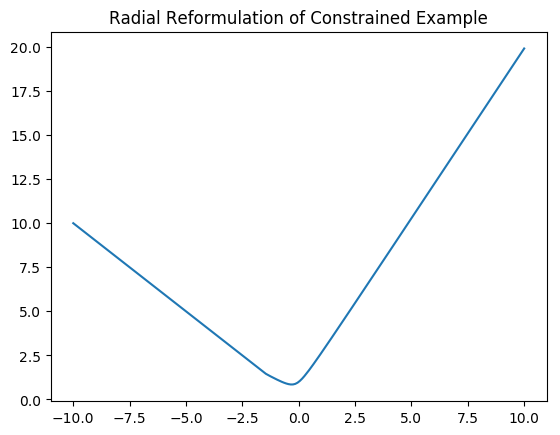

In [8]:
title("Radial Reformulation of Constrained Example")
plot(linspace(-10, 10, 200), gamma_contrived.(linspace(-10, 10, 200)));

Looking at the above plot, it is clear that despite $f$ not having full domain or being Lipschitz continuous, $\gamma_z$ is both full domain and Lipschitz continuous.

### Two Dimensional Example ###
Although the above examples illustrate the central properties of $\gamma_z$, its fun to see it in a slightly higher dimension. To do so, we choose a very simple two dimensional function:

$$ f(x) = \|x\|^2 - 1.$$

Then we plot this and its reformulation using Plotly, which gives an interactive figure.

In [9]:
"Quadratic function shifted down to place the origin inside its epigraph"
function twoDimensionalQuadratic(x)
    norm(x)^2 -3
end

gamma_twoDimensionalQuadratic = radialReformulation(twoDimensionalQuadratic, -1.0);

In [42]:
using PlotlyJS
xrange = linspace(-2, 2, 100)
yrange = linspace(-2, 2, 100)
nx = length(xrange)
ny = length(yrange)
xgrid = repmat(xrange',ny,1)
ygrid = repmat(yrange,1,nx)
data_f = zeros(nx,ny)
data_radial = zeros(nx,ny)
for i in 1:nx
    for j in 1:ny
        data_f[i,j] = twoDimensionalQuadratic([xrange[i] ; yrange[j]])
        data_radial[i,j] = gamma_twoDimensionalQuadratic([xrange[i] ; yrange[j]])
    end
end
trace1 = surface(x=xrange, y=yrange, z=data_f, colorscale="Blues")
traceRef =scatter3d(;x=[0], y=[0], z=[0], mode="markers", name= "Reference", marker_size=5)
trace2 = surface(x=xrange, y=yrange, z=data_radial, colorscale="Oranges")
PlotlyJS.plot([trace1, traceRef])

In [11]:
PlotlyJS.plot(trace2)

# Implementation of the Radial Subgradient Method #

The primary contribution of [[1]](https://arxiv.org/abs/1703.09280) is showing that a simple subgradient method utilizing $\gamma_z$ will converge to a minimizer of $f$ at a rate very similar to the classic rate for applying subgradient methods to Lipschitz continuous functions. This procedure is formally stated in Algorithm 1 in that paper.

To implement this algorithm, we need to have a handle on the subgradients of $f$ and normal vectors of the bounadry of the domain of $f$. Often these objects will be easy to compute in closed form (and if they aren't, tools like autograd may be able to automatically generate them).

We briefly digress to discuss the subgradients and normal vectors of some simple toy problems.

### Subgradients and Normal Vectors of Piecewise Linear Functions and Constraints ###
We have already introduced the problem of minimizing the maximum of a set of linear functions. The subgradients of this function have a simple form:

$$ \partial f(x) = conv(a_i \mid i\in\mathrm{argmax}\{a_i^Tx + b_i\}). $$

Similarly, if one has the linear constraint $a_i^Tx \geq b_i$, then the normal vectors at a point $x$ are given by

$$ N_C(x) = \begin{cases}\{0\} & \text{ if } a_i^Tx < b_i \\ \{\lambda a_i \mid \lambda \geq 0\} & \text{ if } a_i^Tx = b_i \\ \emptyset & \text{ if } a_i^Tx > b_i. \end{cases}$$

In [12]:
"Produces a subgradient of the maximum of linear functions"
function subgrad_maxLinear(x)
    val = maxLinear(x)
    r = A*x + b
    for i in 1:m
        if val == r[i] return A[i,:] end
    end
end;

### Subgradients of a Regression Problem with Sparse Regularizer ###

Consider the following classic regression problem:
$$\min_{x\in R^{n}} \|Cx - d\|^2_2 + \|x\|_1 = \sum_{i=1}^m (c_i^T x - d_i)^2 + \|x\|_1$$

In [43]:
n2,m2 = 10,20
C = randn(m2,n2)
d = randn(m2)

"The objective function"
function obj_RegressionWithSparseRegularizer(x)
    norm(C*x-d)^2 + norm(x,1) - norm(d)^2 -1  #Subtracting the constant norm(d)^2+1 to make the origin negative
end

"Subgradient of the one norm"
function subgrad_norm1(x)
    sign(x)
end

"An element of the subdifferential"
function subgrad_RegressionWithSparseRegularizer(x)
    2*C'*(C*x-d) + subgrad_norm1(x)
end;

### Subgradients of $\gamma_z$ ###

Subgradients of $\gamma_z$ can be computed using the formula given in Proposition 2.4. This states that

$$ \partial \gamma_z(x) = \left\{\frac{\gamma_z(x) \zeta}{\zeta^Tx + z\delta} \mid (\zeta,\delta) \in N_{\mathrm{epi\ }f}((x,z)/\gamma_z(x))\right\}. $$

This is implemented as follows:

In [14]:
"For any function f, this turns a normal vector oracle for f into a subgradient oracle for gammaZ"
function convert_normal(normal_f, gamma, z)
    function subgrad_gamma(x)
        γ = gamma(x)
        ζ,δ = normal_f(x/γ, z/γ)
        return (γ/((ζ'*x)[1] + δ*z)).*ζ
    end
    return subgrad_gamma
end;

This can be simplified when $f$ is continuous everywhere it is finite. Under this condition, normal vectors of its epigraph are exactly the set of $(\zeta, -1)$ for subgradients $\zeta\in \partial f(x)$. For all of the problems we have defined so far in this notebook, this can be used to simplify the subgradient formula for $\gamma_z$ to the following:

$$ \partial \gamma_z(x) = \left\{\frac{\gamma_z(x) \zeta}{\zeta^Tx - z} \mid \zeta\in\partial f(x/\gamma_z(x))\right\}.$$

We will stick with this simplified case for the majority of this notebook. We will return to the more general case with normal vectors at the end of this document to give a linear program solver. This easier formula is implemented in the following code:

In [15]:
"For the class of f described above, this turns a subgradient oracle for f into an oracle for gammaZ"
function convert_subgrad(subgrad_f, gamma, z)
    function subgrad_gamma(x)
        γ = gamma(x)
        ζ = subgrad_f(x/γ)
        return (γ/((ζ'*x)[1] - z)).*ζ
    end
    return subgrad_gamma
end;

### Actual Implementation of the Radial Subgradient Method ###

Now that we have a handle on subgradients, implementing our proposed algorithm is easy. The following code runs our algorithm on any $f$ that is continuous whenever it is finite.

In [16]:
"Run Radial Subgradient Method on a d dimensional function f for T iterations"
function RadialSubgradientMethod(f, subgrad_f, d, T)
    x = zeros(d)
    z = f(x)
    
    min_x, min_z = x,z
    for i in 1:T
        gammaZ = radialReformulation(f, z)
        subgrad_gamma = convert_subgrad(subgrad_f, gammaZ, z)
        
        ζ = subgrad_gamma(x)
        α = 0.01/norm(ζ)^2 #A simple decreasing stepsize sequence rather than the more complex sequence proposed in the paper
        y = x - α*ζ
        
        γ = gammaZ(y)
        x = y/γ
        z = z/γ

        if z < min_z min_x,min_z =x,z end
    end
    return min_x
end;

# Solving Some Simple Problems #

Now we have a basic working implementation of our algorithm. To build some confidence with it, we start by applying it to a handful of simple optimization problems.
We can easily apply it to the examples that we have already defined objective and subgradient functions for.

#### Solving Piecewise Linear Minimization ####

First, we try out minimizing the simple piecewise linear function we previously defined.

In [17]:
sol = RadialSubgradientMethod(maxLinear, subgrad_maxLinear, 1, 50)

println("Initial Objective Value: ",maxLinear(zeros(1)))
println("Final Objective Value:   ",maxLinear(sol));

Initial Objective Value: -1.0728205076516435
Final Objective Value:   -1.2060753850720671


To see how quickly this is converging, we plot the minimum objective value produced by running the algorithm for various numbers of outer iterations. To do so, we need to define a version of our algorithm which will track the minimum objective value seen while the algorithm runs: 

In [18]:
"Run Radial Subgradient Method on a d dimensional function f for T iterations"
function RadialSubgradientMethod_objectiveTracking(f, subgrad_f, d, T)
    obj = zeros(T)
    x = zeros(d)
    z = f(x)
    
    min_x, min_z = x,z
    for i in 1:T
        gammaZ = radialReformulation(f, z)
        subgrad_gamma = convert_subgrad(subgrad_f, gammaZ, z)
        
        ζ = subgrad_gamma(x)
        α = 0.01/norm(ζ)^2 #A simple decreasing stepsize sequence rather than the more complex sequence proposed in the paper
        y = x - α*ζ
        
        γ = gammaZ(y)
        x = y/γ
        z = z/γ

        if z < min_z min_x,min_z =x,z end
        obj[i] = min_z
    end
    return min_x, obj
end;

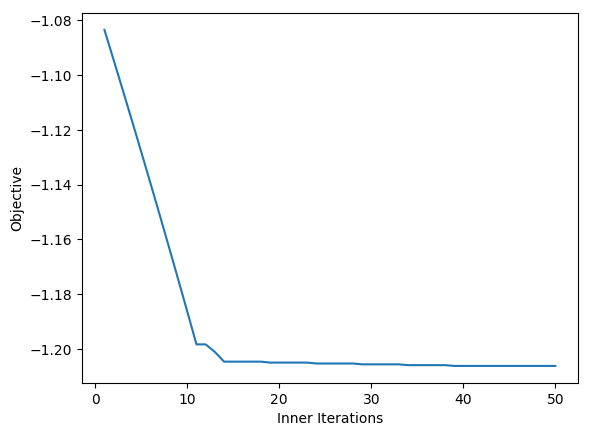

In [19]:
sol, obj = RadialSubgradientMethod_objectiveTracking(maxLinear, subgrad_maxLinear, 1, 50)

using PyPlot
plot(1:50, obj)
xlabel("Inner Iterations")
ylabel("Objective");

We remark that the fact that this plot having large flat regions is to be expected. This is an artifact of our choice of step size rule. We selected $\alpha_k = \epsilon / \|\zeta_k\|^2$ with $\epsilon=0.01$. The step size gives us a consistent gain on objective value. However, it will blow up when we reach a point with very small $\|\zeta_k\|$. This blow up will prevent us from finding a point with subgradient norm much less than $\epsilon$. As a result, we expect the long run behaviour to flatten out about $\epsilon$ above the optimal objective value.

#### Solving Regression with Sparse Regularization ####

In [46]:
sol = RadialSubgradientMethod(obj_RegressionWithSparseRegularizer, subgrad_RegressionWithSparseRegularizer, n2, 350)

println("Initial Objective Value: ",obj_RegressionWithSparseRegularizer(zeros(n2)))
println("Final Objective Value:   ",obj_RegressionWithSparseRegularizer(sol));

Initial Objective Value: -1.0
Final Objective Value:   -9.985133071087049


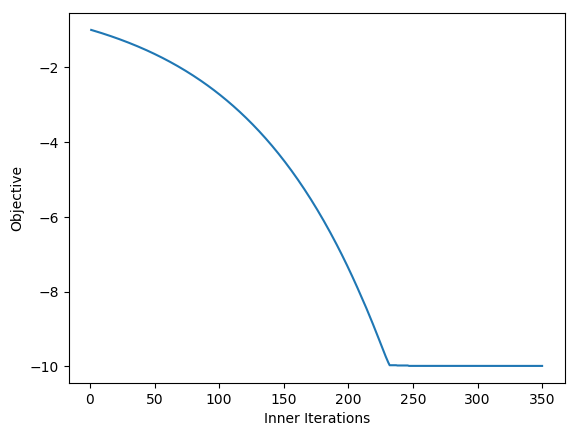

In [48]:
sol, obj = RadialSubgradientMethod_objectiveTracking(obj_RegressionWithSparseRegularizer, subgrad_RegressionWithSparseRegularizer, n2, 350)

plot(1:350, obj)
xlabel("Inner Iterations")
ylabel("Objective");

Just like we expected the objective plot to flatten out for the piecewise linear example problem, we expect this plot to flatten out about $\epsilon=0.01$ above optimal.

# Solving an Interesting Problem - Finding the Analytic Center of a Polyhedron #

Now we consider a more complex problem for which a traditional subgradient method could not be easily applied. For a polytope defined by $Ax \geq b$, the analytic center is
$$ x^* \in \mathrm{argmin}\{-\sum_{i=1}^m \log(a_i^Tx - b_i)\}.$$
Finding this point is a convex optimization problem, but since a logarithm is added in and the function doesnt have full domain, the traditional subgradient method will struggle to solve this problem. There are plenty of more sophisticated ways to solve this problem using smoothness and self-concoordance (as this is central to interior point methods). However, we would like to solve this using a first-order method and the Radial Subgradient Method is the only one I know of that has convergence guarantees for such a problem.

To begin, we consider any polytope for which $\vec 0$ lies in the interior. This is generated by the following code. 

In [22]:
m3,n3 = 100,30
A = randn(m3,n3)
b = -1*rand(m3)-ones(m3);

Since our objective function is differentiable, its subdifferenital is exactly the gradient at each point.

In [23]:
"The objective function"
function obj_analyticCenter(x)
    ret = 0
    R = A*x - b
    for i in 1:m3
        if R[i]<0.0000001 return Inf end
        ret = ret -log(R[i])
    end
    return ret
end

"Gradient formula for the barrier function we are minimizing"
function subgrad_analyticCenter(x)
    ζ = zeros(n3)
    R = A*x - b
    for i in 1:m3
        ζ = ζ-A[i,:]./R[i]
    end
    return ζ
end;

Then we have everything we need to solve the optimization problem:

In [24]:
sol = RadialSubgradientMethod(obj_analyticCenter, subgrad_analyticCenter, n3, 150)

println("Initial Objective Value: ",obj_analyticCenter(zeros(n3)))
println("Final Objective Value:   ",obj_analyticCenter(sol));

Initial Objective Value: -40.3596513582962
Final Objective Value:   -95.91668349924079


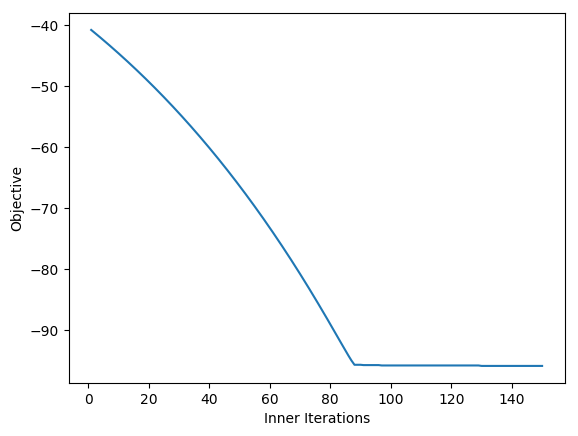

In [25]:
sol, obj = RadialSubgradientMethod_objectiveTracking(obj_analyticCenter, subgrad_analyticCenter, n3, 150)

plot(1:150, obj)
xlabel("Inner Iterations")
ylabel("Objective");

# Solving an Interesting Problem - Linear Programming #

Linear programs (LP) are a central concept in optimization. This transformation gives a simple way to apply first-order methods to LPs. In the remainder of this document, we will illustrate how this method can easily be implemented. We note that for this problem, we do need to consider normal vectors of the epigraph of $f$ to understand $\gamma_z$. As such, we cannot use the previous code implementing the radial subgradient method.

To give a more general implementation of our algorithm, we need to define normal vectors of an LPs epigraph. We suppose we want to solve

$$ \min c^T x$$
$$ \text{s.t. } Ax\geq b$$

Then we rewrite this as

$$\min c^Tx + \delta_{Ax\geq b}(x)$$

where $\delta_{Ax\geq b}(x)$ is the indicator function of our feasible region.

Then we can write down $\gamma_z$ and its subgradients in closed form as follows:

In [26]:
m3,n3 = 200,10
A = randn(m3,n3)
b = -1*rand(m3)-ones(m3); #Enforces zero is a strictly feasible solution
c = randn(n3)

function obj_LP(x)
    if minimum(A*x - b) < 0 
        Inf
    end
    (c'*x)[1] -1.0
end

function gamma_LP(x,z)
    ret = max((c'*x)[1] - z, 0)
    y = A*x
    for i in 1:m3
        if y[i]/b[i] > ret
            ret = y[i]/b[i]
        end
    end
    return ret
end

function subgrad_gamma_LP(x,z)
    #If we are on the objective face, return c
    if  abs( obj_LP(x) - z ) < 10.0^-6
        return c
    end
    #Otherwise find a constraint face that we are on
    val, i = findmin(A*x - b)
    return A[i,:]/b[i]
end;

In [27]:

function radialSubgradientMethod_LP(A,b,c, T)
    obj = zeros(T)
    x = zeros(size(c))
    z = obj_LP(x)
    
    min_x, min_z = x,z
    for i in 1:T
#        gammaZ = radialReformulation(obj_LP, z)
        
        ζ = subgrad_gamma_LP(x,z)
        α = 0.01/norm(ζ)^2 #A simple decreasing stepsize sequence rather than the more complex sequence proposed in the paper
        y = x - α*ζ
        γ = gamma_LP(y, z)
        if γ == 0 return x, Inf, obj end

        x = y/γ
        z = z/γ

        if z < min_z min_x,min_z =x,z end
        obj[i] = min_z
    end
    return min_x, min_z, obj
end;

Before applying this method, we use the `Convex.jl` library to solve this random linear program.

This provides us a baseline for the optimal objective value for us to compare against.

In [28]:
using Convex, SCS

x = Variable(n3);
problem = minimize((c'*x)[1]-1, [A * x >= b])
solve!(problem, SCSSolver(verbose=0))

println("True minimum objective value: ", problem.optval)

True minimum objective value: -2.558181551201478


Now we apply our solver to this linear program for a reasonable number of iterations (say, 1000). Note that the runtime of each of these iterations is one matrix vector multiplication. As a result, this procedure scales up much better than other methods that requires matrix inversion (or linear system solves) each iteration.

In [29]:
x, z, obj = radialSubgradientMethod_LP(A,b,c, 1000)
x,z, obj

println("Initial Objective Value: ",obj_LP(zeros(n3)))
println("Final Objective Value:   ",obj_LP(x));

Initial Objective Value: -1.0
Final Objective Value:   -2.486916507395712


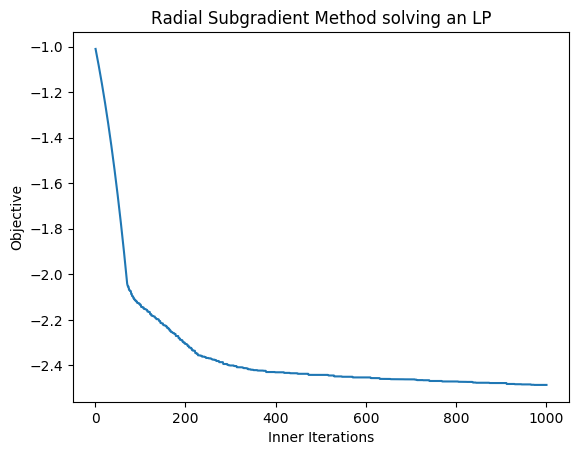

In [30]:
plot(1:1000, obj)
title("Radial Subgradient Method solving an LP")
xlabel("Inner Iterations")
ylabel("Objective");

We see that this method converges fairly quickly to the optimal objective value calulated by `Convex.jl`. Improved convergence could certainly be achieved tuning the stepsize more aggressively. The plot above is given by targetting an accuracy of $\epsilon=0.01$. The convergence seen roughly agrees with our theory since by it is already within relative error of about $\epsilon$ (despite only running $1000$ iterations instead of $10000=\epsilon^{-2}$)